In [1]:
import os
import numpy as np
import pandas as pd

SAVE_DIR = r"D:\Projects\Earthquake\seismic_dataset"
waveform_dir = os.path.join(SAVE_DIR, "waveforms")


if not os.path.exists(waveform_dir):
    raise FileNotFoundError(f" Waveform directory not found: {waveform_dir}")

metadata_path = os.path.join(SAVE_DIR, "metadata.csv")

if not os.path.exists(metadata_path):
    raise FileNotFoundError(f" Metadata CSV not found: {metadata_path}")

metadata_df = pd.read_csv(metadata_path)

print(f" Loaded metadata with {len(metadata_df)} records.")
print(metadata_df.head())

earthquake_metadata = metadata_df[metadata_df['trace_category'] == 'earthquake_local']
noise_metadata = metadata_df[metadata_df['trace_category'] == 'noise']

earthquake_metadata_selected = earthquake_metadata.head(3000)
noise_metadata_selected = noise_metadata.head(2000)

metadata_df_selected = pd.concat([earthquake_metadata_selected, noise_metadata_selected])

metadata_df_selected = metadata_df_selected.sample(frac=1, random_state=42).reset_index(drop=True)

metadata_df_selected["p_arrival_sample"] = metadata_df_selected["p_arrival_sample"].fillna(0).astype(int)


waveforms = []
p_arrivals = []  
trace_categories = []  

for index, file_name in metadata_df_selected["file_name"].items():
    file_path = os.path.join(waveform_dir, file_name)
    
    if os.path.exists(file_path):
        waveform = np.load(file_path)  
        waveforms.append(waveform)
        
        p_arrival_sample = metadata_df_selected["p_arrival_sample"].iloc[index]
        p_arrivals.append(p_arrival_sample)

        trace_category = metadata_df_selected["trace_category"].iloc[index]
        trace_categories.append(trace_category)
    else:
        print(f"Warning: File not found {file_name}")


waveforms = np.array(waveforms, dtype=object)
p_arrivals = np.array(p_arrivals)
trace_categories = np.array(trace_categories)

print(f" Loaded {len(waveforms)} waveforms.")
print(f"Example waveform shape: {waveforms[0].shape}")  

print(f"Loaded metadata for {len(metadata_df_selected)} waveforms.")
print(metadata_df_selected.head())

print(f"First 3 p_arrival_sample values: {p_arrivals[:3]}")
print(f" First 3 trace_category values: {trace_categories[:3]}")

print(f" Waveforms shape: {waveforms.shape}")
print(f" P_arrival_sample shape: {p_arrivals.shape}")
print(f" Trace_categories shape: {trace_categories.shape}")


 Loaded metadata with 25000 records.
                        file_name    trace_category  source_magnitude  \
0   WMTN.ET_20180116083718_NO.npy             noise               NaN   
1   FNSB.CN_20180115055536_NO.npy             noise               NaN   
2   ARSB.KR_20130612170738_EV.npy  earthquake_local              2.60   
3  HASLI.CH_20180115020724_NO.npy             noise               NaN   
4  KAN06.GS_20140915190342_EV.npy  earthquake_local              2.04   

   p_arrival_sample  
0               NaN  
1               NaN  
2             400.0  
3               NaN  
4             499.0  
 Loaded 5000 waveforms.
Example waveform shape: (6000, 3)
Loaded metadata for 5000 waveforms.
                       file_name    trace_category  source_magnitude  \
0   DSC.CI_20160714172433_EV.npy  earthquake_local              2.14   
1  PACP.BK_20070606012000_EV.npy  earthquake_local              2.45   
2  D25K.TA_20180812191000_EV.npy  earthquake_local              2.70   
3  GASB.BK

In [2]:
import numpy as np

waveforms = np.array(waveforms, dtype=np.float32)

print(f"Converted waveforms to NumPy array with shape: {waveforms.shape}")


Converted waveforms to NumPy array with shape: (5000, 6000, 3)


In [3]:
min_vals = np.min(waveforms, axis=1, keepdims=True)
max_vals = np.max(waveforms, axis=1, keepdims=True)


waveforms_minmax = (waveforms - min_vals) / (max_vals - min_vals + 1e-8)

print(f"Applied Min-Max Normalization. Shape: {waveforms_minmax.shape}")


Applied Min-Max Normalization. Shape: (5000, 6000, 3)


In [4]:

mean_vals = np.mean(waveforms, axis=1, keepdims=True)
std_vals = np.std(waveforms, axis=1, keepdims=True)


std_vals[std_vals == 0] = 1e-8  

waveforms_zscore = (waveforms - mean_vals) / std_vals

print(f" Applied Z-score Standardization. Shape: {waveforms_zscore.shape}")


 Applied Z-score Standardization. Shape: (5000, 6000, 3)


In [5]:
print(f"Waveforms shape: {waveforms_zscore.shape}")
print(f"P_arrival_sample shape: {p_arrivals.shape}")
print(f"Trace_categories shape: {trace_categories.shape}")


Waveforms shape: (5000, 6000, 3)
P_arrival_sample shape: (5000,)
Trace_categories shape: (5000,)


In [17]:
import librosa
import numpy as np
spectrograms = []
sample_rate = 100

for i in range(len(waveforms_zscore)):
    waveform = waveforms_zscore[i]  
    waveform_mono = np.mean(waveform, axis=1).astype(np.float32)  
    S = librosa.stft(waveform_mono, n_fft=50, hop_length=12, win_length=20)
    S_db = librosa.power_to_db(np.abs(S) ** 2, ref=np.max)
    spectrograms.append(S_db)

spectrograms = np.array(spectrograms, dtype=object)
print(f"Converted all {len(spectrograms)} waveforms to spectrograms")
print(f"Example spectrogram shape: {spectrograms[0].shape}")

c:\Users\wwwra\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=50 is too large for input signal of length=26
  warnings.warn(


Converted all 5000 waveforms to spectrograms
Example spectrogram shape: (26, 3)


In [57]:
from sklearn.model_selection import train_test_split

HOP_LENGTH = 12  

p_arrivals_scaled = (p_arrivals / HOP_LENGTH).astype(int)

waveforms_zscore = np.transpose(spectrograms, (0, 2, 1))

waveforms_zscore = (waveforms_zscore - waveforms_zscore.mean()) / waveforms_zscore.std()
p_arrival_sample = np.array(p_arrival_sample)
trace_categories = np.array(trace_categories)


waveforms_train, waveforms_temp, p_train, p_temp, cat_train, cat_temp = train_test_split(
    waveforms_zscore, p_arrivals_scaled, trace_categories, test_size=0.3, random_state=42
)

waveforms_val, waveforms_test, p_val, p_test, cat_val, cat_test = train_test_split(
    waveforms_temp, p_temp, cat_temp, test_size=0.5, random_state=42
)

print(f"{'='*60}")
print(f"✅ Train: {len(waveforms_train)}, Validation: {len(waveforms_val)}, Test: {len(waveforms_test)}")
print(f"{'='*60}")
print(f"P-arrival indices scaled from original waveform to spectrogram time axis")
print(f"Original p_arrivals range: {p_arrivals.min()} - {p_arrivals.max()}")
print(f"Scaled p_arrivals range: {p_arrivals_scaled.min()} - {p_arrivals_scaled.max()}")
print(f"Waveform shape: {waveforms_zscore.shape}")
print(f"{'='*60}")

✅ Train: 3500, Validation: 750, Test: 750
P-arrival indices scaled from original waveform to spectrogram time axis
Original p_arrivals range: 0 - 1815
Scaled p_arrivals range: 0 - 151
Waveform shape: (5000, 3, 26)


In [58]:

gaussian_sigma = 3
sample_rate=100
gaussian_sigma_samples = gaussian_sigma * sample_rate 

def apply_gaussian_labels(waveforms, p_arrival_samples, trace_categories):
    labels = []

    for i, (waveform, p_arrival_sample, category) in enumerate(zip(waveforms, p_arrival_samples, trace_categories)):
        n_samples = waveform.shape[0]
        full_label = np.zeros(n_samples)
        is_earthquake = category == 'earthquake_local'

        if is_earthquake and p_arrival_sample > 0:
            start_sample = max(0, int(p_arrival_sample - 3 * gaussian_sigma_samples))
            end_sample = min(n_samples, int(p_arrival_sample + 3 * gaussian_sigma_samples + 1))

            for t in range(start_sample, end_sample):
                full_label[t] = np.exp(-0.5 * ((t - p_arrival_sample) / gaussian_sigma_samples) ** 2)

        labels.append(full_label)

    return np.array(labels)


y_train = apply_gaussian_labels(waveforms_train, p_train, cat_train)
y_val = apply_gaussian_labels(waveforms_val, p_val, cat_val)
y_test = apply_gaussian_labels(waveforms_test, p_test, cat_test)

print(f"Gaussian labels applied with σ = 0.027 sec. Shapes: Train {y_train.shape}, Val {y_val.shape}, Test {y_test.shape}")


Gaussian labels applied with σ = 0.027 sec. Shapes: Train (3500, 3), Val (750, 3), Test (750, 3)


In [56]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Conv1DTranspose, MultiHeadAttention, LayerNormalization,
                                     Dropout, Concatenate, Cropping1D, UpSampling1D)
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=3, activation='relu', dilation_rate=1):
    """Convolution block with dilation support."""
    x = Conv1D(filters, kernel_size, padding='same', activation=activation, dilation_rate=dilation_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same', activation=activation, dilation_rate=dilation_rate)(x)
    return x

def self_attention_block(x, num_heads=4, key_dim=64):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = LayerNormalization()(x + attn_output)
    return x

def unet_plus_plus_dilated(input_shape=(500, 3), num_classes=1):  
    inputs = Input(input_shape)

    c1 = conv_block(inputs, 64, dilation_rate=1)  
    d1 = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=2)(c1)  

    c2 = conv_block(d1, 128, dilation_rate=2)
    d2 = Conv1D(128, 3, padding='same', activation='relu', dilation_rate=4)(c2)

    c3 = conv_block(d2, 256, dilation_rate=4)
    d3 = Conv1D(256, 3, padding='same', activation='relu', dilation_rate=8)(c3)

    c4 = conv_block(d3, 512, dilation_rate=8)
    d4 = Conv1D(512, 3, padding='same', activation='relu', dilation_rate=16)(c4)

    c5 = conv_block(d4, 1024, dilation_rate=16)
    c5 = Dropout(0.5)(c5)

   
    c5 = self_attention_block(c5)

    u4 = UpSampling1D(size=2)(c5)
    u4 = Conv1D(512, 3, padding='same', activation='relu')(u4)  
    u4 = Cropping1D(cropping=(0, u4.shape[1] - c4.shape[1]))(u4) 
    u4 = Concatenate()([c4, u4])
    u4 = conv_block(u4, 512)

    u3 = UpSampling1D(size=2)(u4)
    u3 = Conv1D(256, 3, padding='same', activation='relu')(u3)
    u3 = Cropping1D(cropping=(0, u3.shape[1] - c3.shape[1]))(u3)
    u3 = Concatenate()([c3, u3])
    u3 = conv_block(u3, 256)

    u2 = UpSampling1D(size=2)(u3)
    u2 = Conv1D(128, 3, padding='same', activation='relu')(u2)
    u2 = Cropping1D(cropping=(0, u2.shape[1] - c2.shape[1]))(u2)
    u2 = Concatenate()([c2, u2])
    u2 = conv_block(u2, 128)

    u1 = UpSampling1D(size=2)(u2)
    u1 = Conv1D(64, 3, padding='same', activation='relu')(u1)
    u1 = Cropping1D(cropping=(0, u1.shape[1] - c1.shape[1]))(u1)
    u1 = Concatenate()([c1, u1])
    u1 = conv_block(u1, 64)

    outputs = Conv1D(num_classes, 1, activation='linear')(u1)

    model = Model(inputs, outputs)
    return model


model = unet_plus_plus_dilated(input_shape=(500, 3))  
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 3)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 500, 64)      640         ['input_2[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 500, 64)      12352       ['conv1d_3[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 500, 64)      12352       ['conv1d_4[0][0]']               
                                                                                            

In [ ]:
import tensorflow as tf
import gc


tf.keras.backend.clear_session()
gc.collect()


70

: 

In [60]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [61]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Conv1DTranspose, MultiHeadAttention, LayerNormalization,
                                     Dropout, Concatenate, Cropping1D, UpSampling1D)
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=3, activation='relu', dilation_rate=1):
    x = Conv1D(filters, kernel_size, padding='same', activation=activation, dilation_rate=dilation_rate)(x)
    return x


def small_model(input_shape=(3,26), num_classes=1):  
    inputs = Input(input_shape)
    c1 = conv_block(inputs, 64, dilation_rate=1)  
    d1 = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=2)(c1)  

    outputs = Conv1D(num_classes, 1, activation='linear')(d1)

    model = Model(inputs, outputs)
    return model


model2 = small_model(input_shape=(3,26))  
model2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 26)]           0         
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             5056      
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 1)              65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [62]:
import tensorflow as tf
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


def smape_loss(y_true, y_pred):
    epsilon = 0.1 
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return smape

def smape_metric(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return tf.reduce_mean(smape)


X_train = waveforms_train.astype(np.float16)
X_val = waveforms_val.astype(np.float16)
y_train = y_train.astype(np.float16)
y_val = y_val.astype(np.float16)

X_test=waveforms_test.astype(np.float16)
y_test=y_test.astype(np.float16)

BATCH_SIZE = 8
def create_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)   


model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=smape_loss,
    metrics=smape_metric
)

history = model2.fit(train_dataset, validation_data=val_dataset, epochs=50)

Physical devices cannot be modified after being initialized
Epoch 1/50
438/438 [==============================] - 3s 5ms/step - loss: 0.7921 - smape_metric: 0.7918 - val_loss: 0.7457 - val_smape_metric: 0.7454
Epoch 2/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7346 - smape_metric: 0.7344 - val_loss: 0.7413 - val_smape_metric: 0.7410
Epoch 3/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7309 - smape_metric: 0.7306 - val_loss: 0.7394 - val_smape_metric: 0.7390
Epoch 4/50
438/438 [==============================] - 2s 4ms/step - loss: 0.7290 - smape_metric: 0.7288 - val_loss: 0.7363 - val_smape_metric: 0.7360
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 0.7279 - smape_metric: 0.7276 - val_loss: 0.7369 - val_smape_metric: 0.7365
Epoch 6/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7273 - smape_metric: 0.7270 - val_loss: 0.7341 - val_smape_metric: 0.7338
Epoch 7/50
438/438 [====================

In [63]:
import tensorflow as tf
tf.keras.models.save_model(model2, "earthquake_small_model")

INFO:tensorflow:Assets written to: earthquake_small_model\assets


INFO:tensorflow:Assets written to: earthquake_small_model\assets


In [64]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def smape_loss(y_true, y_pred):
    epsilon = 0.1 
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return smape

def smape_metric(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return tf.reduce_mean(smape)

loaded_model = tf.keras.models.load_model(
    "earthquake_small_model",
    custom_objects={'smape_loss': smape_loss, 'smape_metric': smape_metric}
)



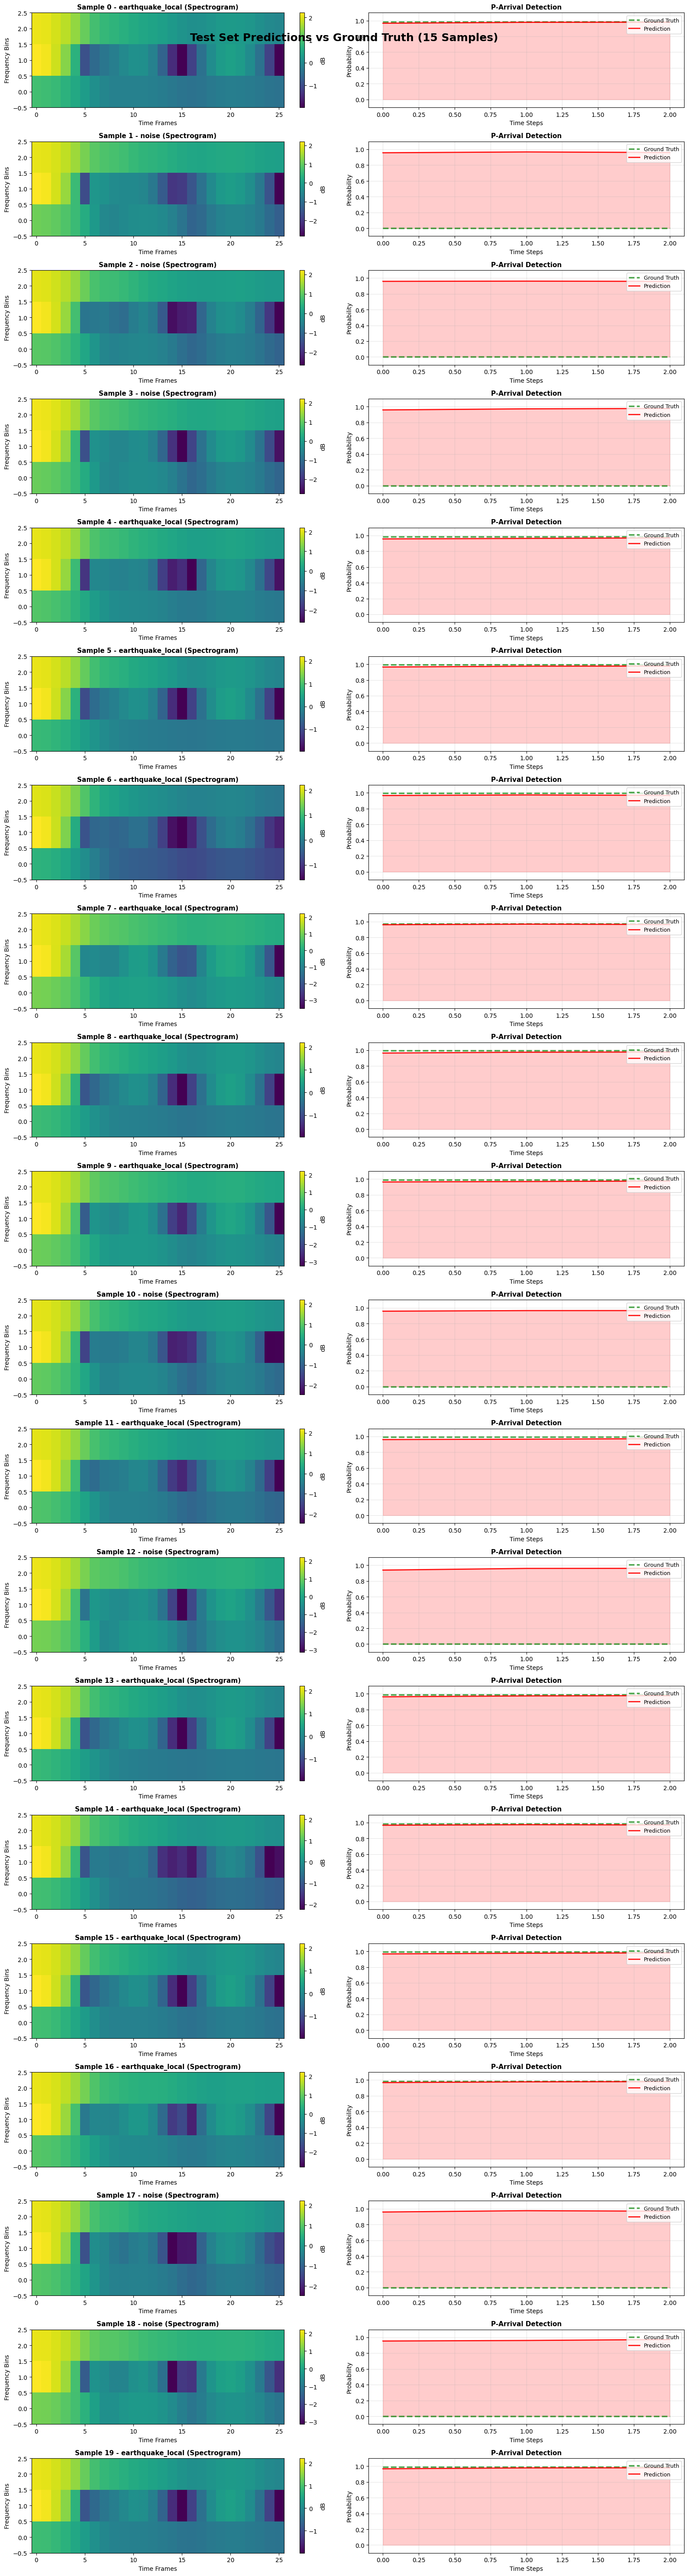


✅ Test visualization complete!
Showing 20 test samples with predictions


In [65]:
import matplotlib.pyplot as plt
import numpy as np

X_test_final = waveforms_test.astype(np.float16)
y_test_final = y_test.astype(np.float16)

y_pred_test = loaded_model.predict(X_test_final, verbose=0).squeeze()


num_samples = min(20, len(X_test_final))
fig, axes = plt.subplots(num_samples, 2, figsize=(16, 3*num_samples))
fig.suptitle('Test Set Predictions vs Ground Truth (15 Samples)', fontsize=18, fontweight='bold')

for row in range(num_samples):
    sample_idx = row
    
    if sample_idx < len(X_test_final):
        test_sample = X_test_final[sample_idx]
        ground_truth = y_test_final[sample_idx]
        prediction = y_pred_test[sample_idx]
        category = cat_test[sample_idx]
        ax_left = axes[row, 0]
        spectrogram = test_sample.astype(np.float32)
        im = ax_left.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
        ax_left.set_title(f'Sample {sample_idx} - {category} (Spectrogram)', fontsize=11, fontweight='bold')
        ax_left.set_xlabel('Time Frames')
        ax_left.set_ylabel('Frequency Bins')
        plt.colorbar(im, ax=ax_left, label='dB')
        ax_right = axes[row, 1]
        x_axis = np.arange(len(prediction))
        ax_right.plot(x_axis, ground_truth, color='green', linewidth=2.5, label='Ground Truth', linestyle='--', alpha=0.7)
        ax_right.plot(x_axis, prediction, color='red', linewidth=2, label='Prediction', alpha=0.9)
        ax_right.fill_between(x_axis, prediction, alpha=0.2, color='red')
        ax_right.set_xlabel('Time Steps')
        ax_right.set_ylabel('Probability')
        ax_right.set_title(f'P-Arrival Detection', fontsize=11, fontweight='bold')
        ax_right.legend(loc='upper right', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"✅ Test visualization complete!")
print(f"Showing {num_samples} test samples with predictions")
print(f"{'='*60}")

In [ ]:
def segment_data(x, y, window_samples, stride_samples):
    X_windows = []
    y_windows = []
    num_waveforms = x.shape[0]
    
    for i in range(num_waveforms):
        waveform = x[i]
        label = y[i]
        n_samples = waveform.shape[0]
        
        for start in range(0, n_samples - window_samples + 1, stride_samples):
            end = start + window_samples
            X_windows.append(waveform[start:end, :])
            y_windows.append(label[start:end])
    return np.array(X_windows), np.array(y_windows)
window_samples = 100
stride_samples = 250   
X_train_final, y_train_final = segment_data(waveforms_train, y_train, window_samples, stride_samples)
X_val_final, y_val_final = segment_data(waveforms_val, y_val, window_samples, stride_samples)
X_test_final, y_test_final = segment_data(waveforms_test, y_test, window_samples, stride_samples)

print(f"Final X_train shape: {X_train_final.shape}, y_train shape: {y_train_final.shape}")

print(f"Final X_test shape: {X_test_final.shape}, y_train shape: {y_test_final.shape}")